In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


from sklearn import metrics

from sklearn.model_selection import cross_val_score, GridSearchCV ,cross_val_predict, KFold, StratifiedKFold, ShuffleSplit, train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix , r2_score
from heapq import nlargest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV , ElasticNet


import warnings
warnings.filterwarnings('ignore')

## Regression on Ames Housing Dataset

You can load the Ames housing dataset from <br>
http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls <br>
You can find a description of the variables here: <br>
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt <br>

In [2]:
df = pd.read_excel("AmesHousing.xls")
df.head()
# df.describe()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**Visualizing the univariate distribution of each continuous attribute, and the distribution of the target.**

37


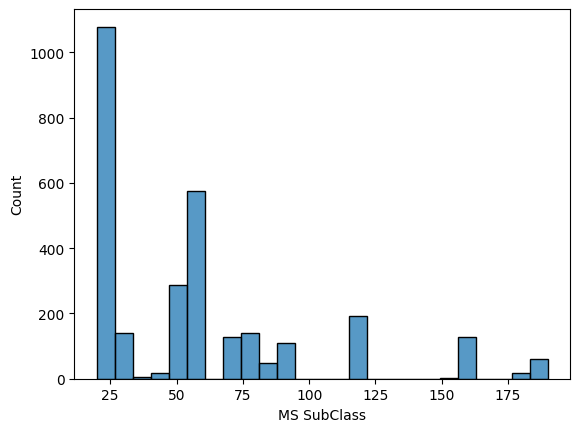

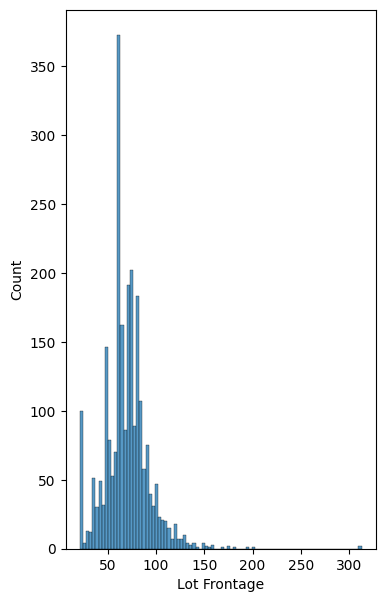

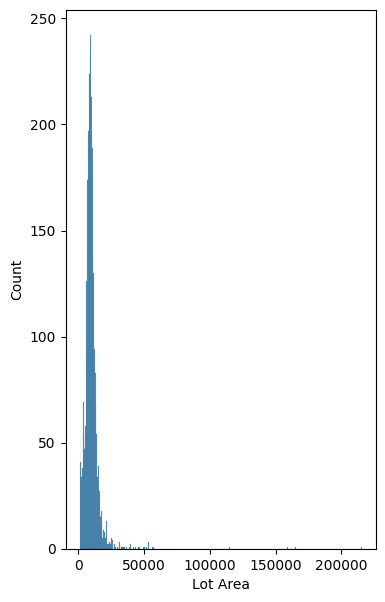

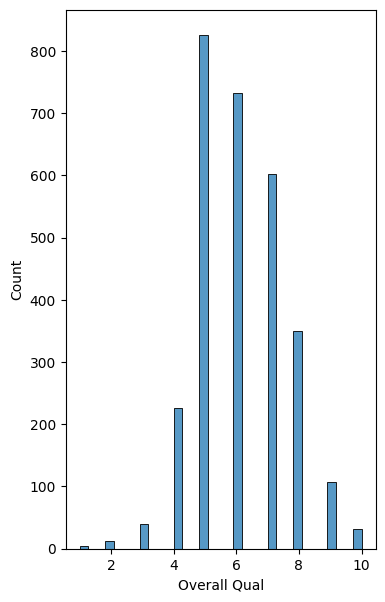

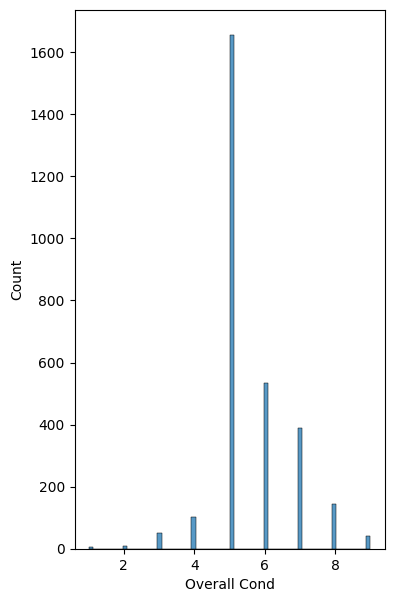

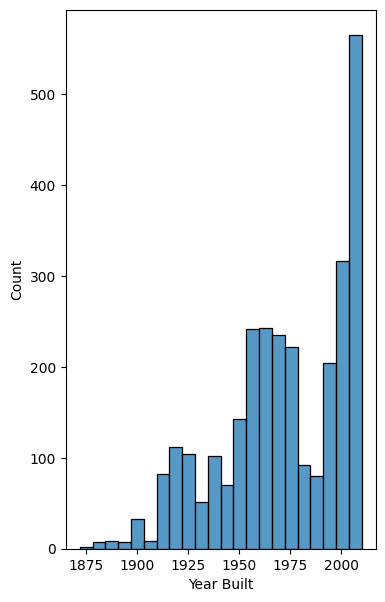

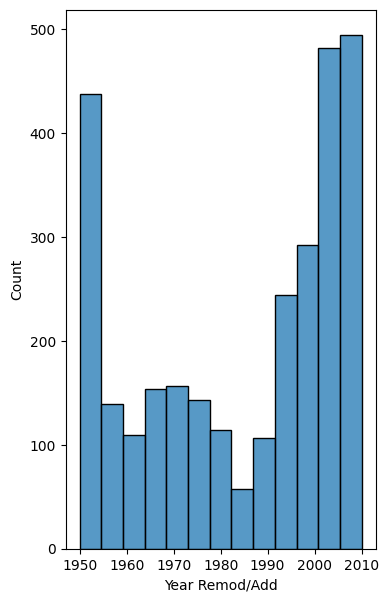

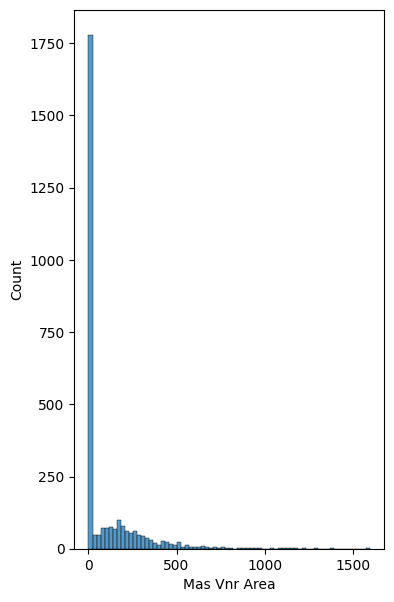

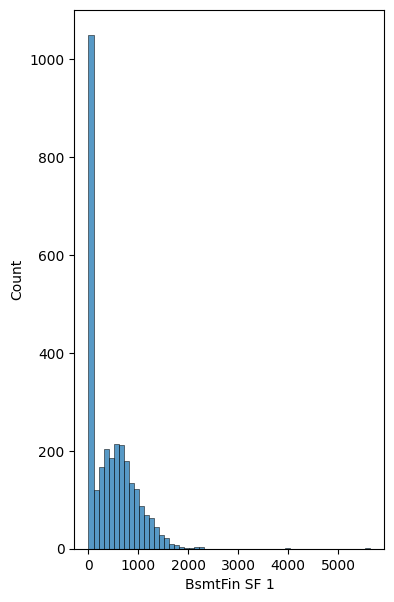

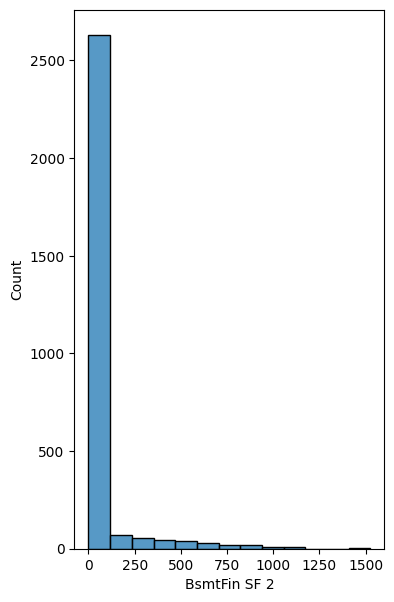

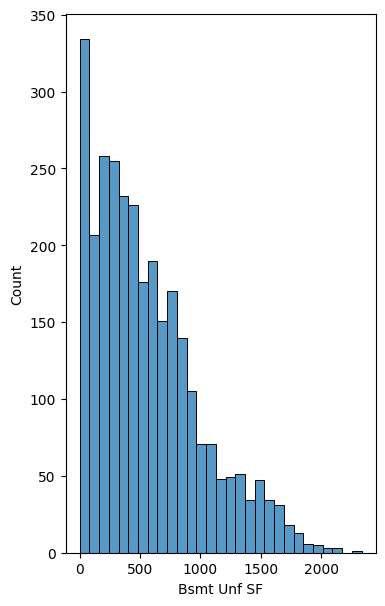

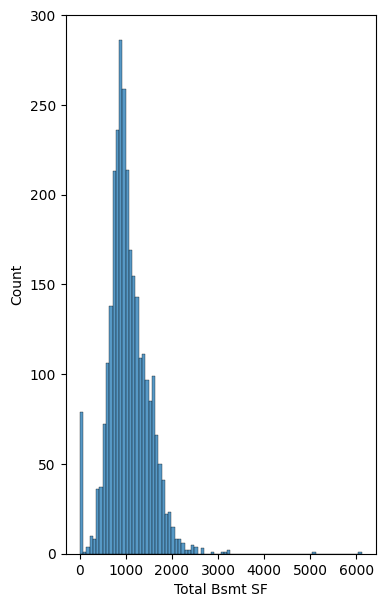

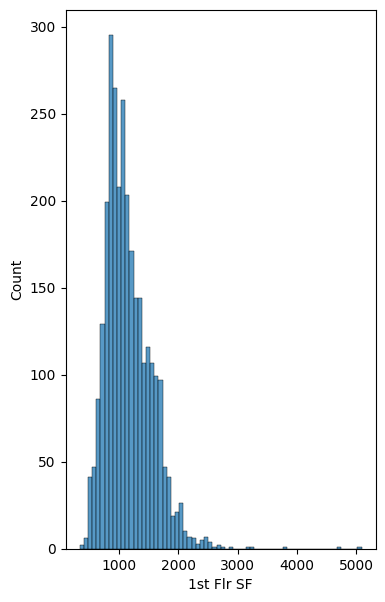

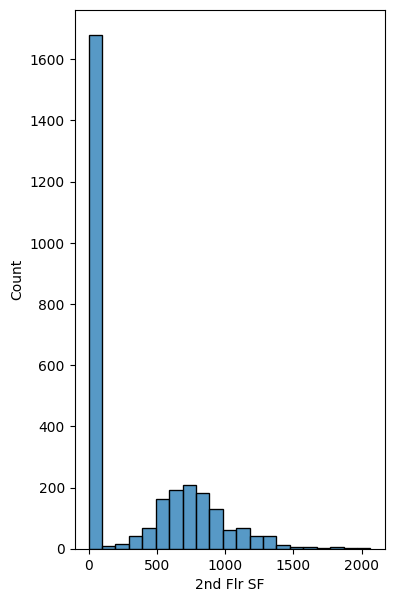

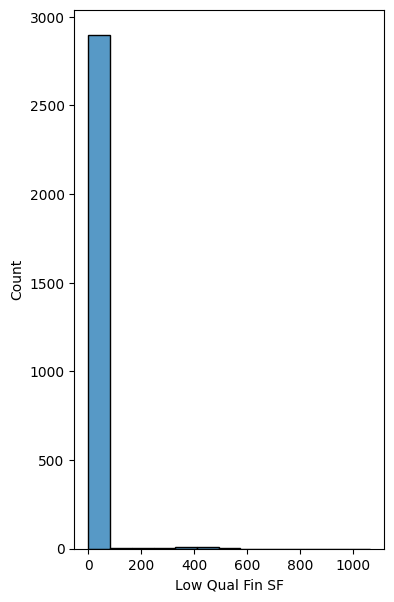

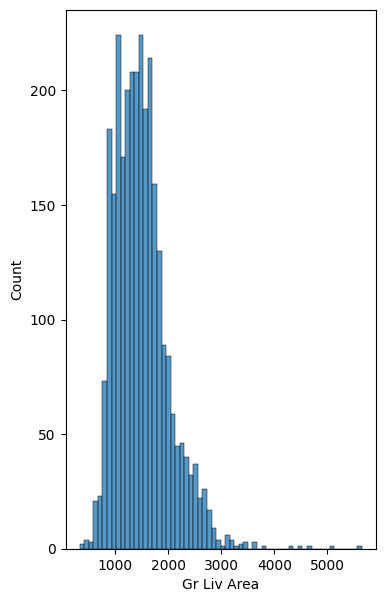

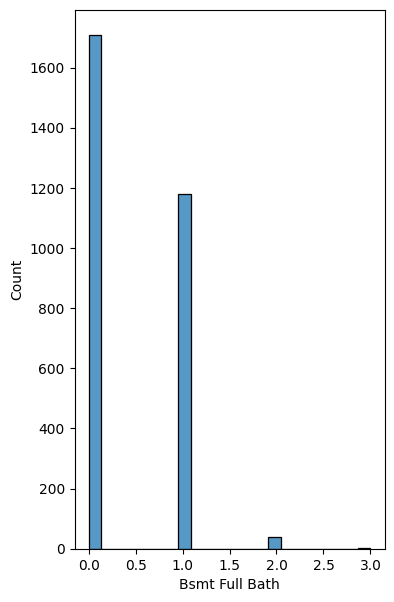

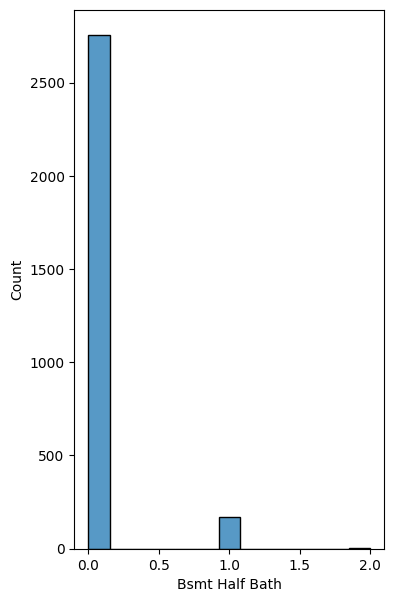

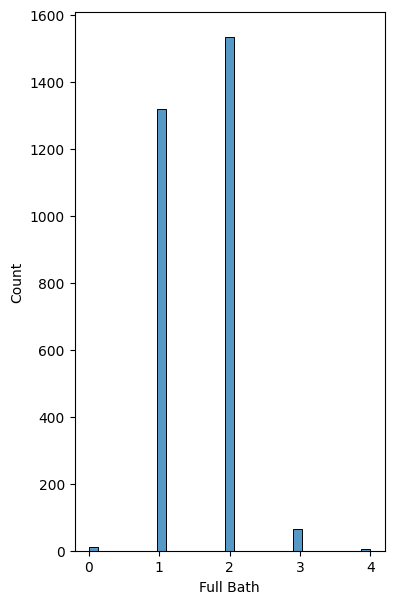

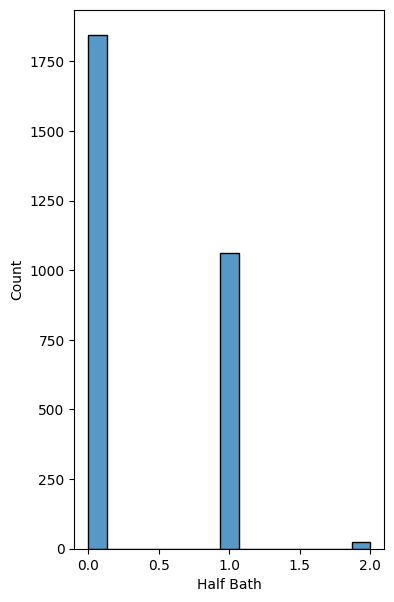

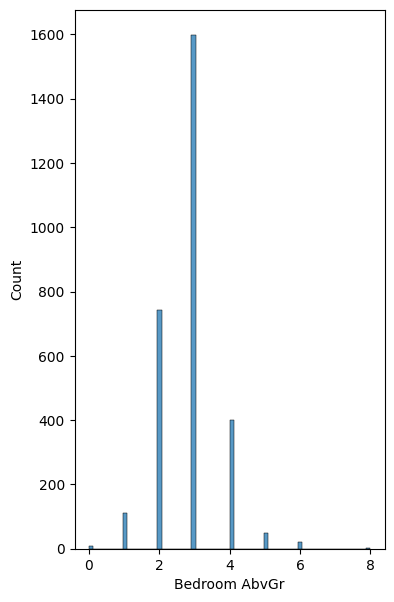

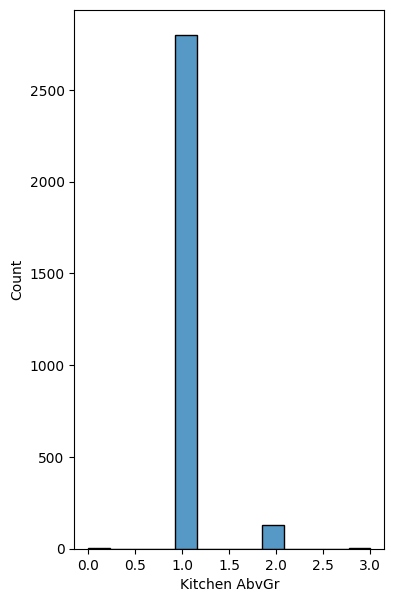

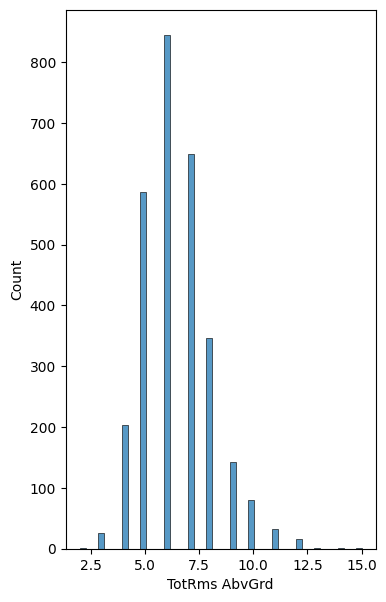

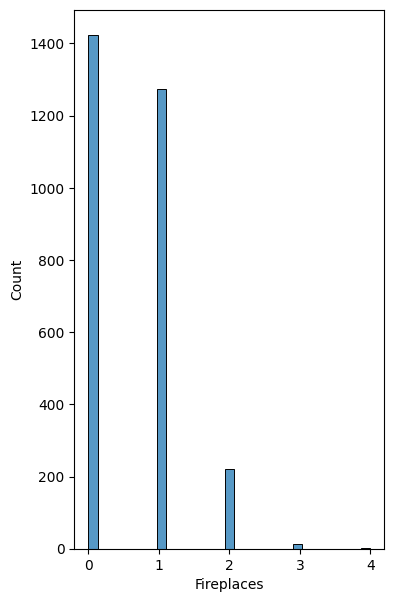

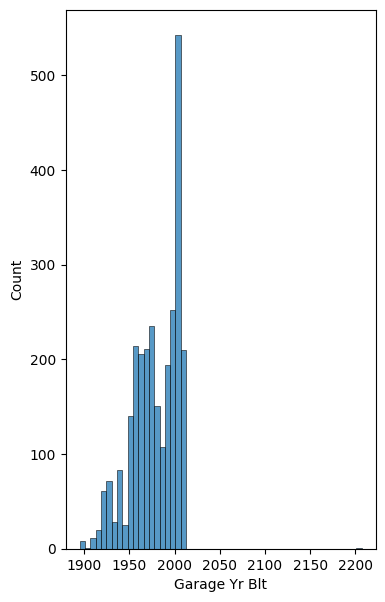

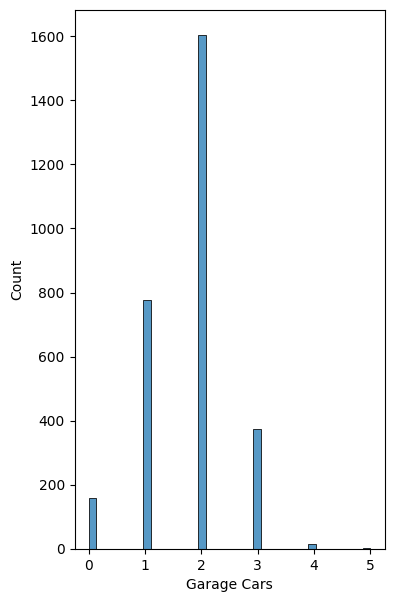

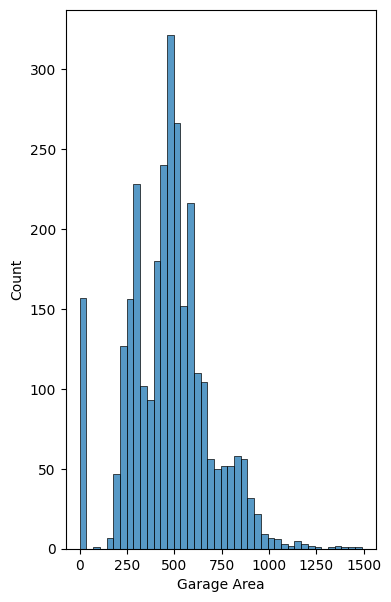

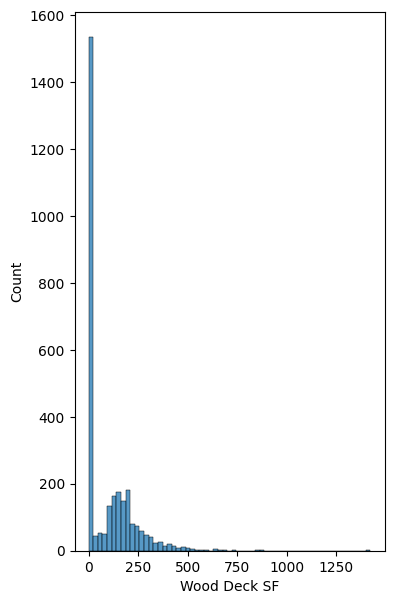

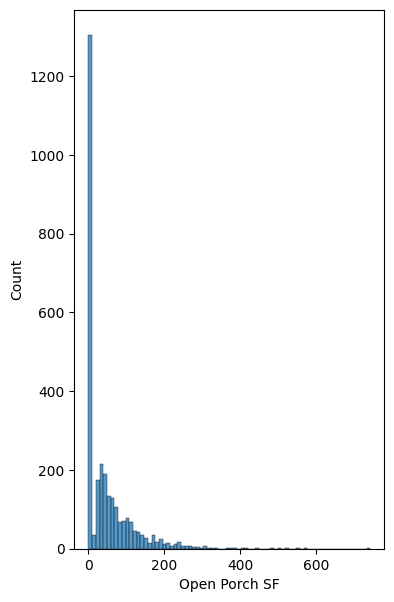

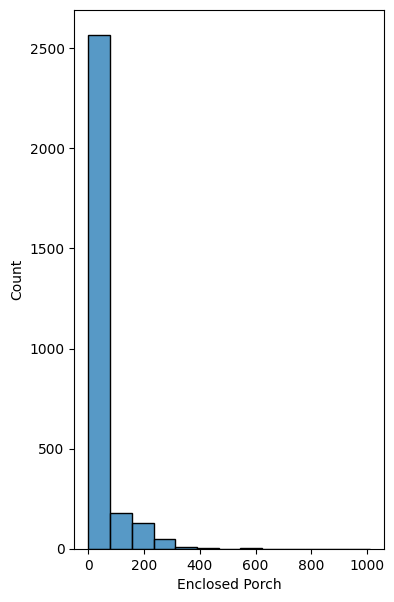

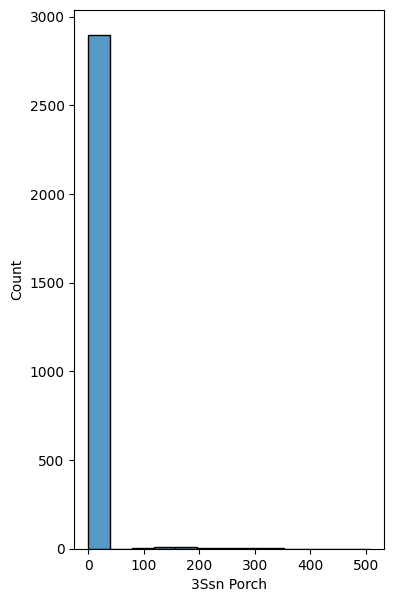

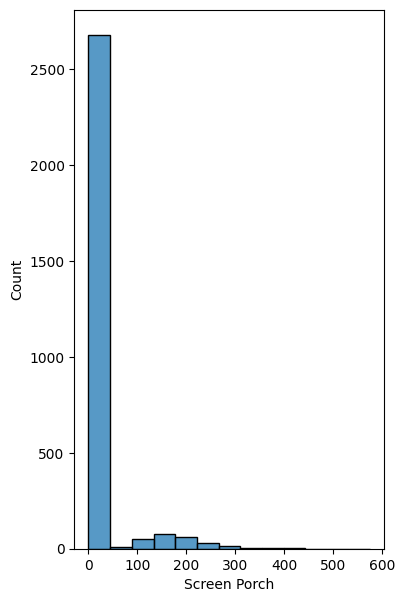

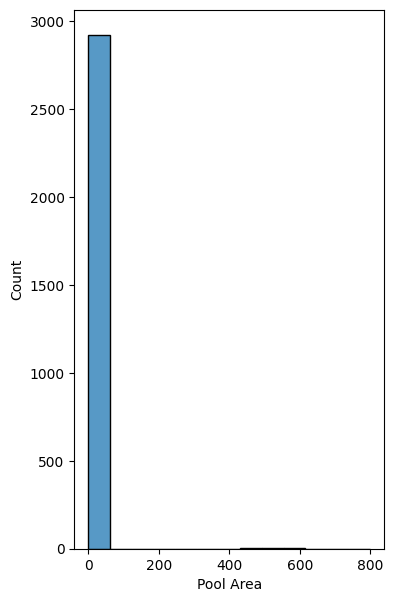

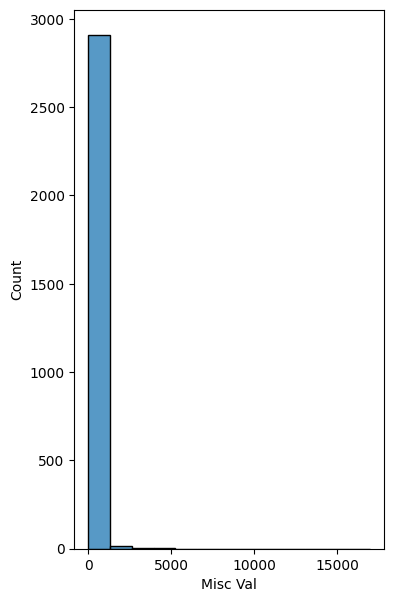

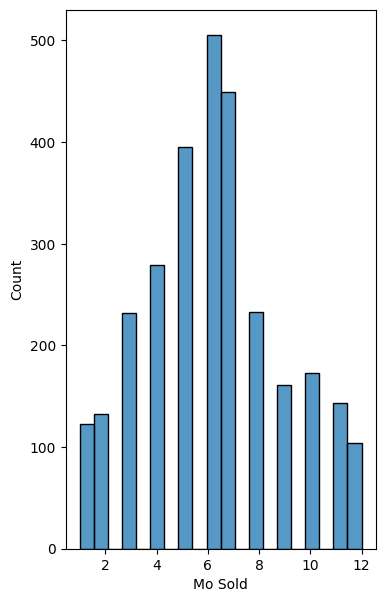

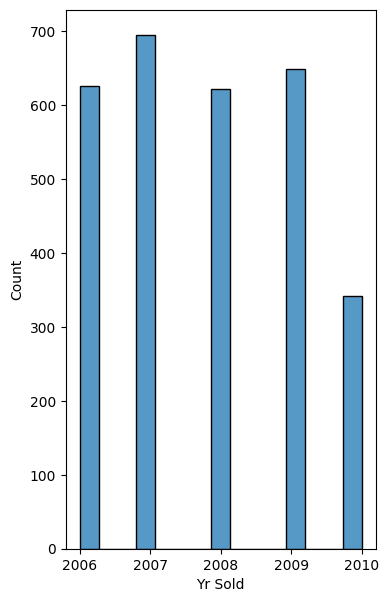

<Figure size 400x700 with 0 Axes>

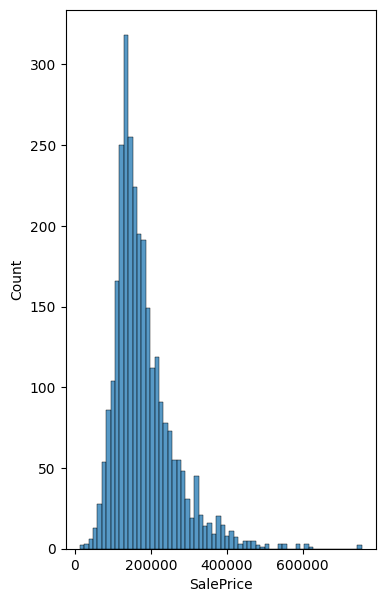

In [3]:
non_catg_features = df.select_dtypes(exclude=['object']).drop(columns=['PID','Order'])
target = df['SalePrice']
print(len(non_catg_features.columns))

plt.rcParams.update({'figure.max_open_warning': 0})
for i, col in enumerate(non_catg_features.columns):
    plt.figure(figsize=(4,7))
    plt.figure(i)
    sns.histplot(non_catg_features[col])
    


We can see that thhere are features that are normaly distributed and there are features that seems less informative due to low variance in data. 

some of the features could be more usefull if they were scaled.

**Visualizing the dependency of the target on each continuous feature.**

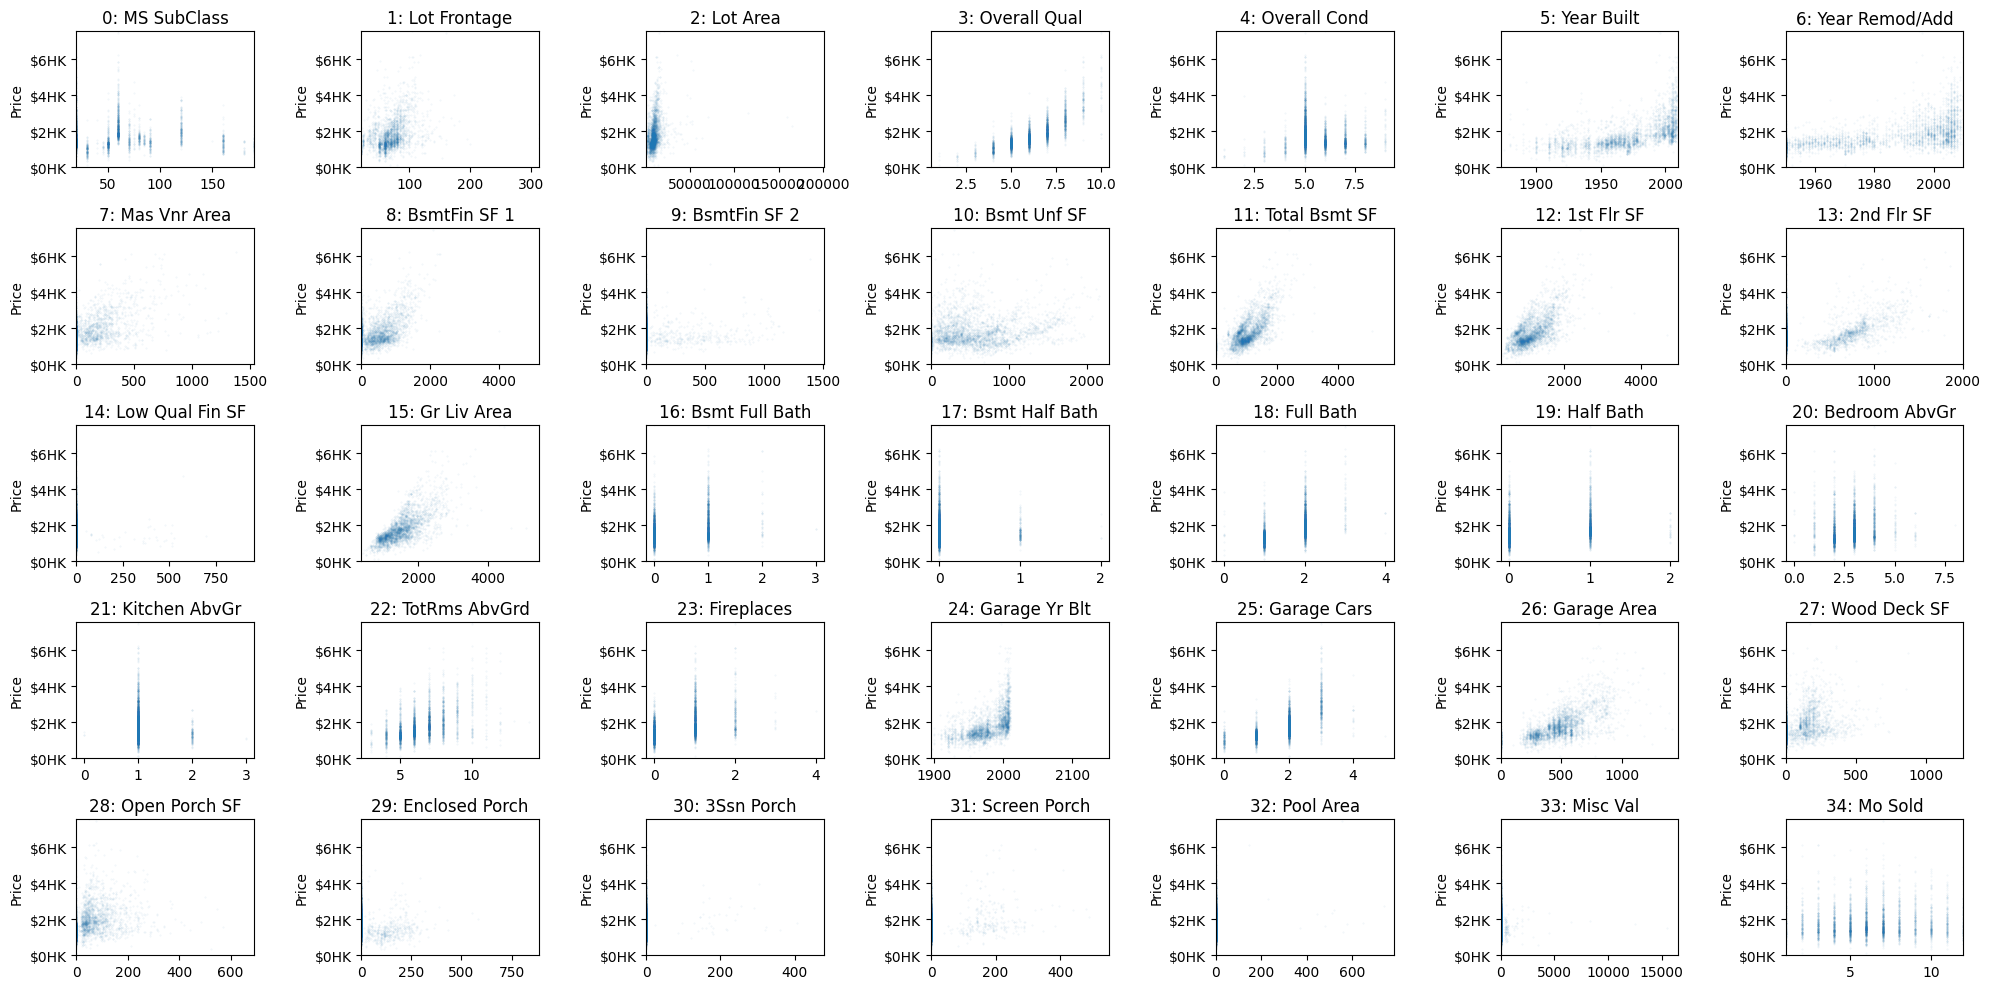

In [4]:
non_catg_features.drop(columns=['SalePrice'], inplace=True)

def thousend_formatter(x, pos):
    return f"${int(x / 10 ** 5)}HK" # Stands for hundred


fig, axes = plt.subplots(5, 7, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 38:
        ax.set_visible(False)
        continue
    X_col = non_catg_features.iloc[:, i]
    #X_col = X_global_scaled.iloc[:, i]
    ax.yaxis.set_major_formatter(thousend_formatter)
    # set ticks to disregard outliers
    ax.set_ylim(0, 755000)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
    ax.scatter(X_col, target, alpha=.1, s=.1)
    ax.set_title("{}: {}".format(i, non_catg_features.columns[i]))
    ax.set_ylabel("Price")
plt.tight_layout()

In [5]:
X = df.drop(columns=['SalePrice', 'PID','Order',])
y = target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42, shuffle=False)


print("train shape ",X_train.shape)
print("train label shape ",y_train.shape)
print("test shape ",X_test.shape)
print("test label shape ",y_test.shape)

train shape  (2344, 79)
train label shape  (2344,)
test shape  (586, 79)
test label shape  (586,)


In [6]:
linear = LinearRegression()
list_cat= X.select_dtypes(include='O').keys()
list_cat

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')

**For each categorical variable, cross-validating a Linear Regression model using just this variable
(with one-hot-encoded).**

In [7]:
dic={}
for col in list_cat:
    df_temp =X_train[col]
    dummies = pd.get_dummies(df_temp,drop_first=True)
    cross = cross_val_predict(linear, dummies, y_train, cv = 5)
    dic[col] = metrics.r2_score(y_true= y_train, y_pred=cross)
#     print('r2 score', metrics.r2_score(y_true= y_train, y_pred=cross))
    

print(dic)

{'MS Zoning': 0.09771434502424636, 'Street': -0.01500449462895559, 'Alley': -0.018294778007363233, 'Lot Shape': 0.06783689870690346, 'Land Contour': 0.022854418443432833, 'Utilities': -0.017688738505896806, 'Lot Config': -0.001942295860941412, 'Land Slope': -0.015814025318873215, 'Neighborhood': 0.5510002718733432, 'Condition 1': 0.03031672359167359, 'Condition 2': 0.006803702267859091, 'Bldg Type': 0.00883428785071072, 'House Style': 0.05009896130834601, 'Roof Style': 0.05770810500745416, 'Roof Matl': -0.016897791947860563, 'Exterior 1st': 0.1658590305568176, 'Exterior 2nd': 0.1588578745464233, 'Mas Vnr Type': 0.19915540652120833, 'Exter Qual': 0.5135568921982614, 'Exter Cond': 0.014408286366510814, 'Foundation': 0.27835141682539954, 'Bsmt Qual': 0.3247958892615832, 'Bsmt Cond': 0.025794377688040493, 'Bsmt Exposure': 0.13089280811570514, 'BsmtFin Type 1': 0.21378737911830836, 'BsmtFin Type 2': 0.0003900008547312872, 'Heating': -7.63493381147354e+24, 'Heating QC': 0.2110937414499835, '

In [8]:
ThreeHighest = nlargest(3, dic, key = dic.get)
 
print("Dictionary with 3 highest values:")
print("Keys: Values")
 
for val in ThreeHighest:
    print(val, ":", dic.get(val))

Dictionary with 3 highest values:
Keys: Values
Neighborhood : 0.5510002718733432
Exter Qual : 0.5135568921982614
Kitchen Qual : 0.4729280837246246


**Visualizing the relationship of the categorical variables that provide the best
R^2 value with the target.**

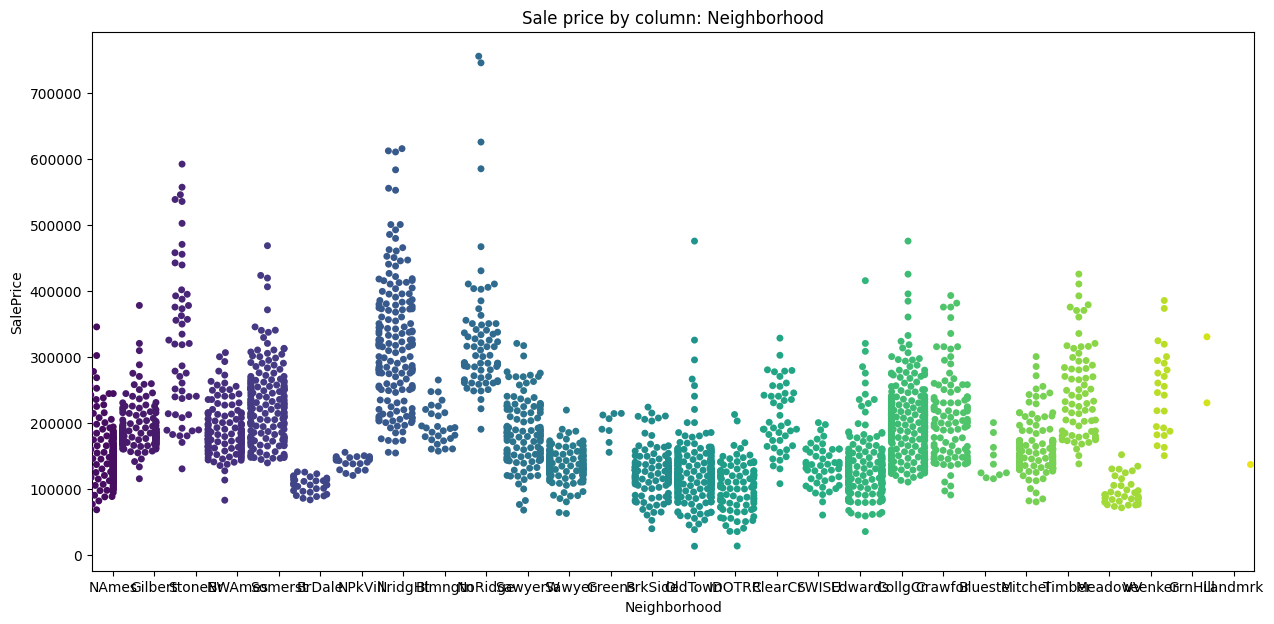

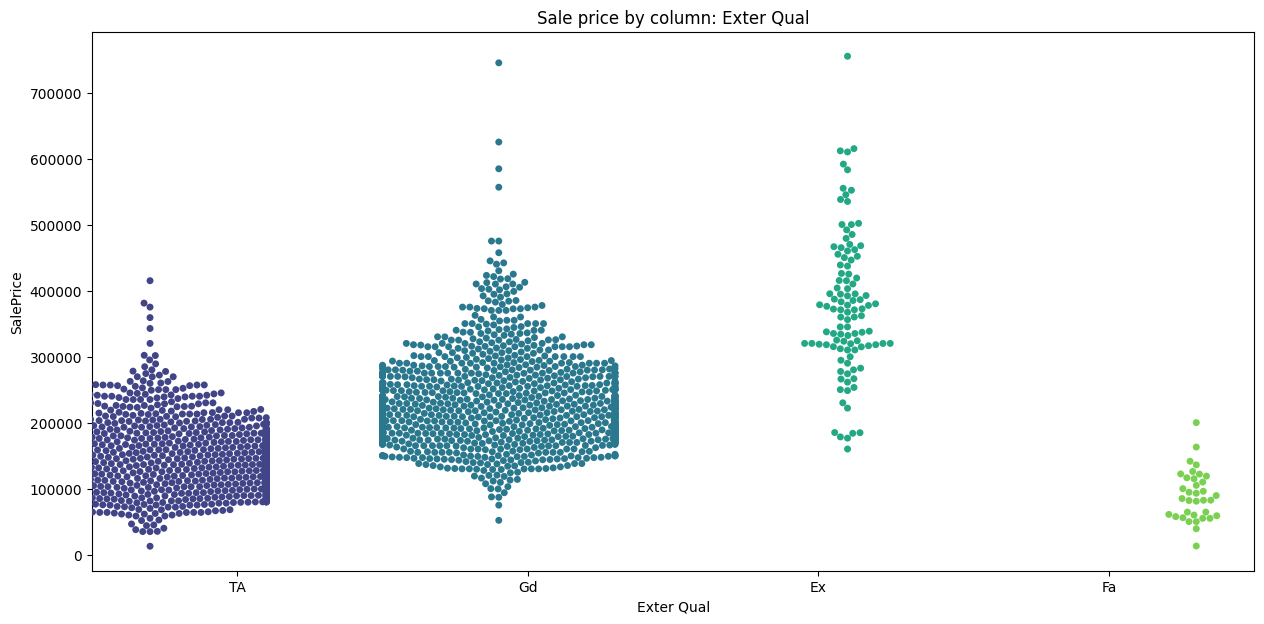

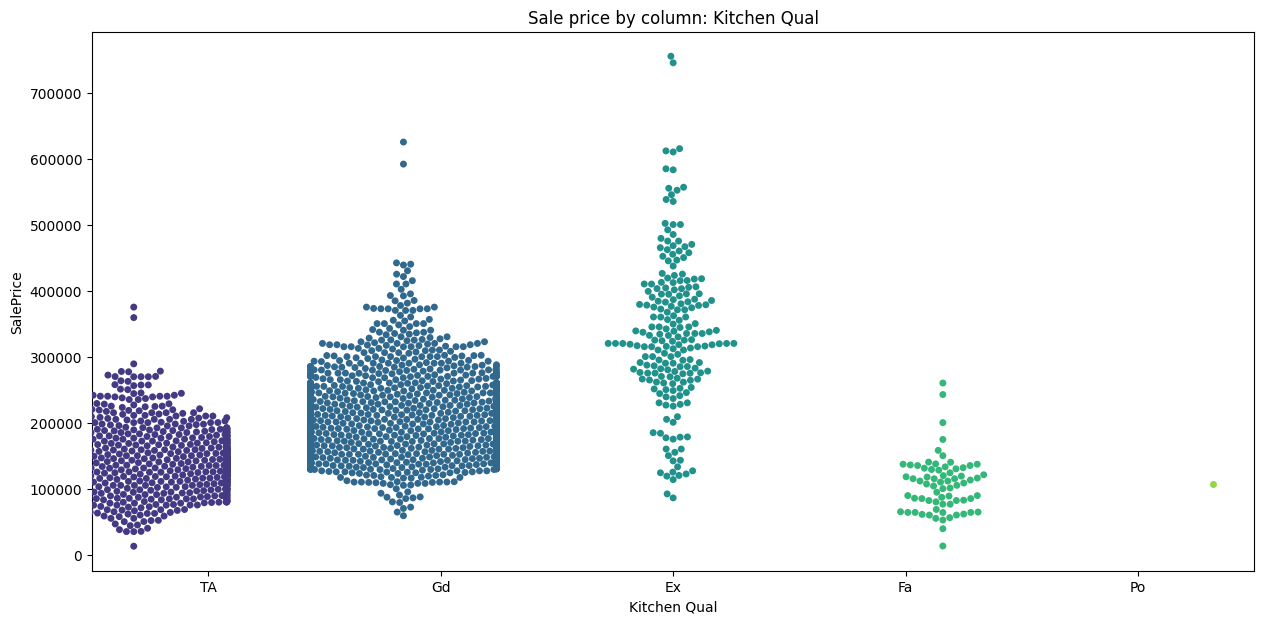

In [9]:
for val in ThreeHighest:
    plt.figure(figsize=(15,7))
    sns.swarmplot(x=df[val] , y=df.SalePrice, data=X_train, dodge=True, palette='viridis')
    plt.title("Sale price by column: " + val)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2440 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            198 non-null    object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

In [11]:
binary_features = X.columns[X.isin([0,1]).all()]
binary_features

Index([], dtype='object')

**Building pipelines and evaluating diffrent regression models.**

In [12]:
# Filling missing values with mean
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

# steps=[("scaler", StandardScaler())])

# Making dummies
categorical_features = X_train.select_dtypes(include=object).columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# First we use the numeric_transformer in order to not accedently scale the binary values produced from OneHotEncoder
preprocessor = ColumnTransformer(
transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
  ]
  )


classifiers = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet()
]
    
    
for classifier in classifiers:
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    pipeline = Pipeline(steps)
    print(np.mean(cross_val_score(pipeline, X_train, y_train, cv=10)))


0.792749599740969
0.8142040831171371
0.8027390734735288
0.7945369909959712


Without the scaling the scores were:
1. For LinearRegression the scroe was 0.74
2. For Ridge the scroe was 0.75
3. For Lasso the scroe was 0.74
4. For ElasticNet the scroe was 0.59


**Tunning the parameters of the models using GridSearch and elbow method.**

classifier Ridge() params {'clf__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
results_Ridge
Grids best estimators:  Ridge(alpha=10.0)


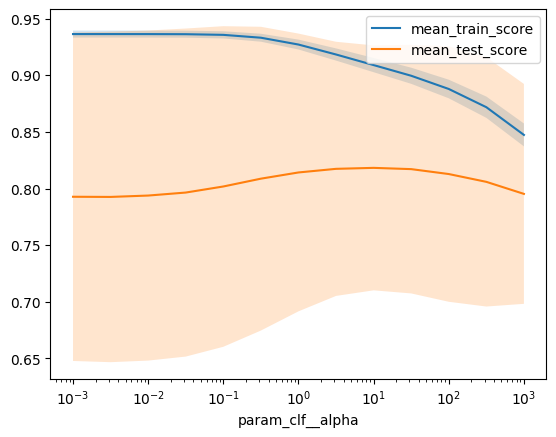

classifier Lasso() params {'clf__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
results_Lasso
Grids best estimators:  Lasso(alpha=31.622776601683793)


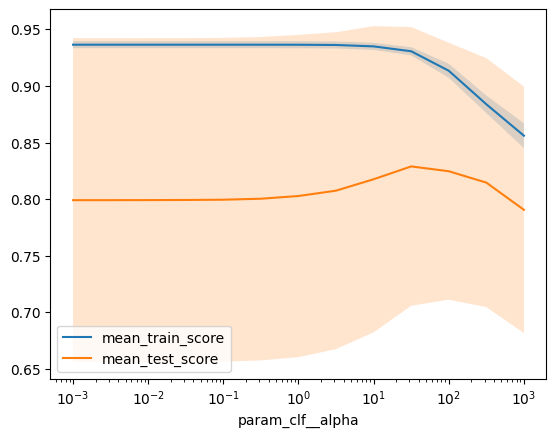

classifier ElasticNet() params {'clf__alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]), 'clf__l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.98, 1]}
results_ElasticNet
Grids best estimators:  ElasticNet(alpha=21.54434690031882, l1_ratio=1)


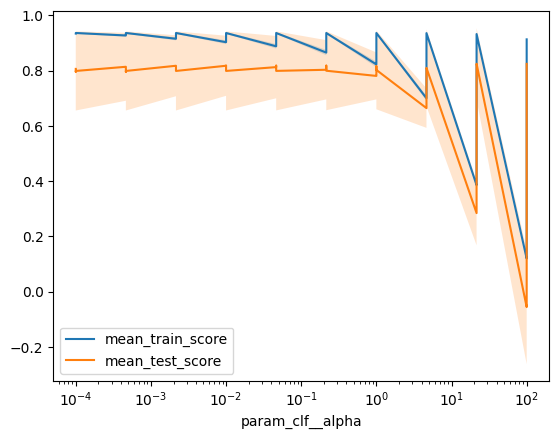

In [13]:
classifiers = [
    Ridge(),
    Lasso(),
    ElasticNet()
]

param_grid = [{'clf__alpha': np.logspace(-3, 3, 13)},
              {'clf__alpha': np.logspace(-3, 3, 13)},
              {'clf__alpha': np.logspace(-4, 2, 10),
              'clf__l1_ratio': [0.01, .1, .5, .9, .98, 1]}]

classifiers_names = [
    'Ridge',
    'Lasso',
    'ElasticNet'
]


for classifier, params, name in zip(classifiers, param_grid, classifiers_names):
    print("classifier",classifier , "params", params)
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline, params, cv=10, return_train_score=True)
    grid.fit(X_train, y_train)
    
    exec('results_{} = pd.DataFrame(grid.cv_results_)'.format(name))
    exec('print("results_{}")'.format(name))
    
    print("Grids best estimators: ", grid.best_estimator_.steps[1][1])
    
    results = pd.DataFrame(grid.cv_results_)
#     print(results)
    results.plot('param_clf__alpha', 'mean_train_score')
    results.plot('param_clf__alpha', 'mean_test_score', ax=plt.gca())
    plt.fill_between(results.param_clf__alpha.astype(np.float),
                     results['mean_train_score'] + results['std_train_score'],
                     results['mean_train_score'] - results['std_train_score'], alpha=0.2)
    plt.fill_between(results.param_clf__alpha.astype(np.float),
                     results['mean_test_score'] + results['std_test_score'],
                     results['mean_test_score'] - results['std_test_score'], alpha=0.2)
    plt.legend()
    plt.xscale("log")
    plt.show()


**Visualizing the coefficients of the resulting models.**

In [14]:
# grid.best_estimator_.steps[1][1]

steps_Ridge = [("preprocessor", preprocessor),
        ("clf", Ridge(alpha=10.0))]
pipeline_Ridge = Pipeline(steps_Ridge).fit(X_train, y_train)


steps_Lasso = [("preprocessor", preprocessor),
        ("clf", Lasso(alpha=100.0))]
pipeline_Lasso = Pipeline(steps_Lasso).fit(X_train, y_train)

steps_ElasticNet = [("preprocessor", preprocessor),
        ("clf", ElasticNet(alpha=100.0, l1_ratio=1))]
pipeline_ElasticNet = Pipeline(steps_ElasticNet).fit(X_train, y_train)

cat_names =  pipeline_Ridge.named_steps['preprocessor'].transformers_[1][1].get_feature_names(categorical_features)
num_names = pipeline_Ridge.named_steps['preprocessor'].transformers_[0][2]

# print(len(cat_names))
# print(len(num_names))

feature_names = num_names.copy()

for i in cat_names:
    feature_names.append(i)

pipeline_list = [pipeline_Ridge, pipeline_Lasso, pipeline_ElasticNet]
pipline_names = ['Ridge', 'Lasso', 'ElasticNet']
for pipeline, name in zip(pipeline_list, pipline_names):
    model_coefficients = pipeline.named_steps['clf'].coef_
    coefficients_df = pd.DataFrame(data = model_coefficients, 
                                  index = feature_names, 
                                  columns = ['Coefficient_value'])
    coefficients_df.sort_values("Coefficient_value", inplace=True)


    coefficients_df.tail(10).plot.barh(figsize=(6, 4),color='g')
    plt.title("10 Highest Coefficient Values of {}'s Model".format(name))
    plt.axvline(x=0, color=".5")
    plt.xlabel("Raw coefficient values")
    plt.subplots_adjust(left=0.3)
#     plt.show()
    
    coefficients_df.head(10).plot.barh(figsize=(6, 4),color='r')
    plt.title("10 Least Coefficient Values of {}'s Model".format(name))
    plt.axvline(x=0, color=".5")
    plt.xlabel("Raw coefficient values")
    plt.subplots_adjust(left=0.3)
    plt.show()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

Using: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

The different models agree on the feature importance on several features (high and low).

## Classification on the Telco-churn dataset

You can download the dataset and see it’s description at <br>
https://www.kaggle.com/blastchar/telco-customer-churn

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
# Turning Yes into 1 and No into 0
df.Churn=(df.Churn=='Yes').astype('int')
df.head().T
# df.describe(include='all').T

In [ ]:
X = df.drop(columns=['customerID', 'Churn'])
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42, shuffle=False)


In [ ]:
X[X.select_dtypes(include=['object']).columns].nunique()

# We can use OneHotEncoder in here with drop = 'first', the fetures who have only 2 values will stay as one col.
# There aren't any Categorical-Ordinal features which need to be addressed differently.

**Building a pipeline for dealing with categorical variables and 
Evaluate Logistic Regression and nearest centroids using
cross-validation.**

In [ ]:
# Filling missing values with mean
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
# numeric_transformer = Pipeline(
#     steps=[("scaler", MinMaxScaler(feature_range=(0, 1)))]
#     )
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
    )

# Making dummies
categorical_features = X_train.select_dtypes(include=object).columns.tolist()
categorical_transformer = OneHotEncoder(drop='first',handle_unknown="ignore")


# First we use the numeric_transformer in order to not accedently scale the binary values produced from OneHotEncoder
preprocessor = ColumnTransformer(
transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
  ]
  )

classifiers = [
    LogisticRegression(),
    NearestCentroid()
]

classifiers_names = [
    'LogisticRegression',
    'NearestCentroid'
]
    
    
for classifier, name in zip(classifiers, classifiers_names):
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]

    pipeline = Pipeline(steps)
    print("{}'s mean score is:".format(name), np.mean(cross_val_score(pipeline, X_train, y_train, cv=10)))
    

Without the scaling the scores were:

1. For LogisticRegression the scroe was 0.78
2. For NearestCentroid the scroe was 0.67

In [ ]:
probs = pipeline.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Churn users')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Tunning the parameters using GridSearchCV.**

In [ ]:
classifiers = [
    LogisticRegression(),
    NearestCentroid()
]

param_grid = [{'clf__C': np.logspace(-4, 4, 50),
              'clf__penalty': ['l1', 'l2']},

              {'clf__shrink_threshold' : np.arange(0, 1.01, 0.01),
                'clf__metric': ['euclidean', 'manhattan']}]

classifiers_names = [
    'LogisticRegression',
    'NearestCentroid'
]


for classifier, params, name in zip(classifiers, param_grid, classifiers_names):
    print("classifier",classifier , "params", params)
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline, params, cv=10, return_train_score=True)
    grid.fit(X_train, y_train)
    
    exec('results_{} = pd.DataFrame(grid.cv_results_)'.format(name))
    exec('print("results_{}")'.format(name))
    
    print("Grids best estimators: ", grid.best_estimator_.steps[1][1])
    

**Changing the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling to see if the parameters that are found have changed.**

In [ ]:
classifiers = [
    LogisticRegression(),
    NearestCentroid()
]

param_grid = [{'clf__C': np.logspace(-4, 4, 50),
              'clf__penalty': ['l1', 'l2']},

              {'clf__shrink_threshold' : np.arange(0, 1.01, 0.01),
                'clf__metric': ['euclidean', 'manhattan']}]

classifiers_names = [
    'LogisticRegression',
    'NearestCentroid'
]

# From what I saw in the documentation, GridSearchCV will use the same shuffling for each set
# of parameters validated by a single call to its fit method either way.
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

for classifier, params, name in zip(classifiers, param_grid, classifiers_names):
    print("classifier",classifier , "params", params)
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline, params, cv=kfold, return_train_score=True)
    grid.fit(X_train, y_train)
    
    exec('results_{} = pd.DataFrame(grid.cv_results_)'.format(name))
    exec('print("results_{}")'.format(name))
    
    print("Grids best estimators: ", grid.best_estimator_.steps[1][1])
    


When using the KFold (instead of StratifiedKFold) with Suffle=True the parameters that changed were:

For LogisticRegression it changed from C=0.013 to C=1.75

And for NearestCentroid nothing has changed.

When changing the random state, the parameters stayed the same.